In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Bringing in Data

In [2]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

In [3]:
bsize = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/MN.csv")

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
nrg = nrg.reset_index()
bsize = bsize.reset_index()

# Scatterplot 1 - Exploratory Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f185e6ee890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1843e21510>]], dtype=object)

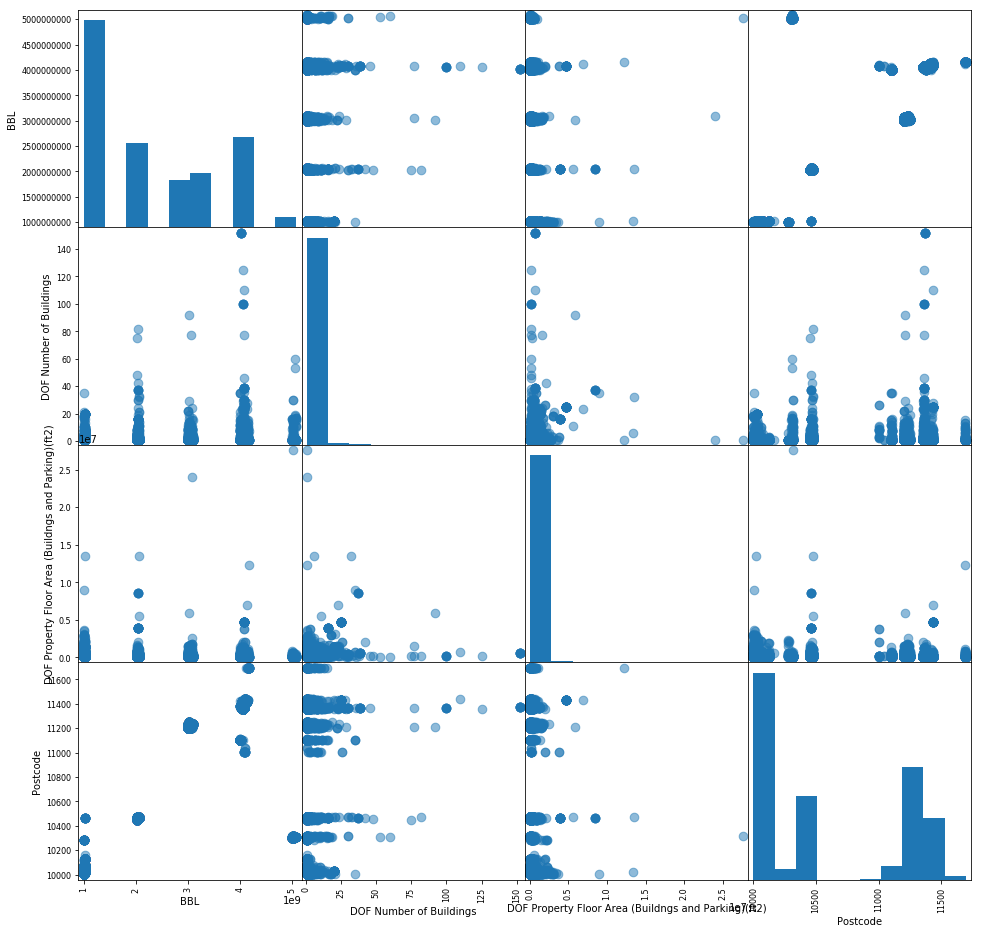

In [5]:
nrg_scatter1 =nrg[['BBL', "DOF Number of Buildings",\
                   'DOF Property Floor Area (Buildngs and Parking)(ft2)', "Postcode"]]
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_scatter1, s=300, figsize=(16, 16))

This is a matrix of scatterplots - each cell has an x and y value, which can be seen on the far left and bottom of the graph.

This does not give us much useful information, beyond providing some interesting distributions of # of buildings and floor area by postcode.

# Merging Datasets

In [6]:
bsize_merge = bsize[["BBL", "YearBuilt", "UnitsTotal", "UnitsRes"]]
nrg_merge = nrg[["BBL", "Site EUI(kBtu/ft2)", 'Reported Property Floor Area (Building(s)) (ft²)']]

In [7]:
nrg_merge = nrg_merge.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
bsize_merge = bsize_merge.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))

In [8]:
bblnrgdata = pd.merge(nrg_merge, bsize_merge, on='BBL').dropna()

# Scatterplot 2 - Merged Datasets

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1841efac50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f182c4fe210>]], dtype=object)

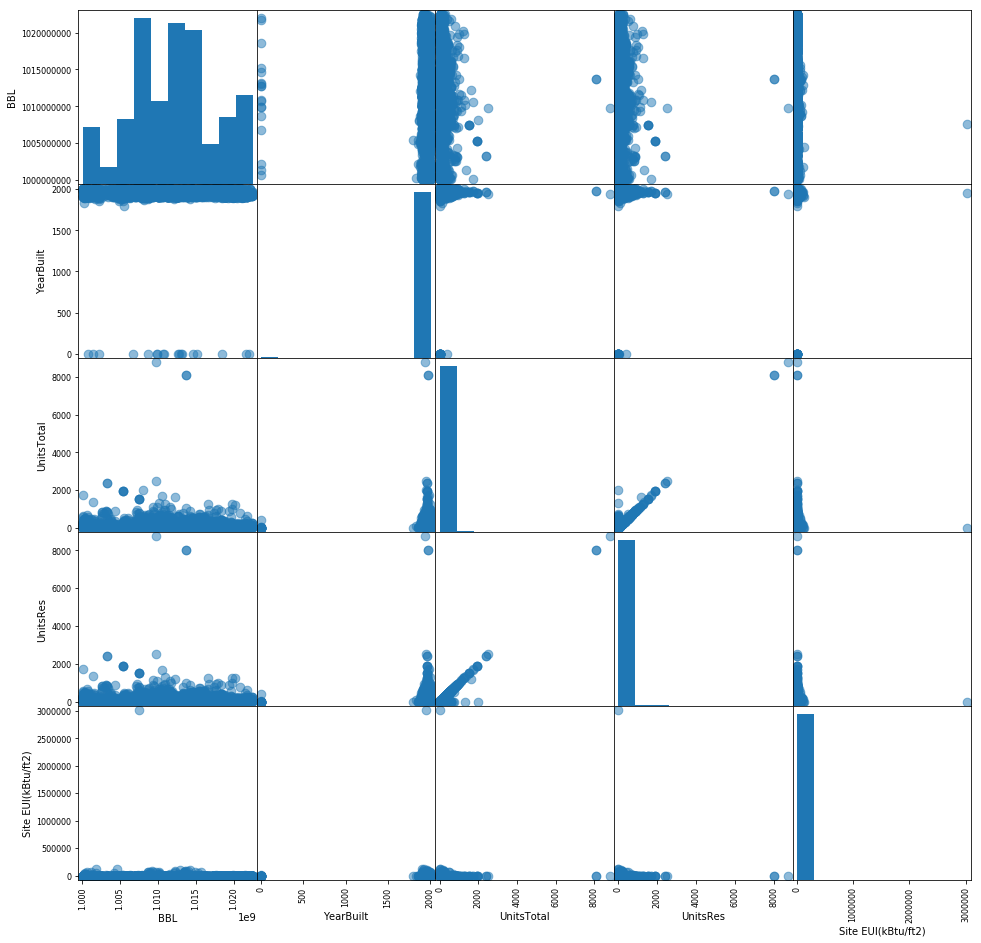

In [9]:
scatter_matrix(bblnrgdata[["BBL", "YearBuilt", "UnitsTotal", "UnitsRes", "Site EUI(kBtu/ft2)"]]\
                , s=300, figsize=(16, 16))

This is a matrix of scatterplots - each cell has an x and y value, which can be seen on the far left and bottom of the graph. This matrix combines energy and building data.

There is a clear positive relationship between total units and residential units. One can also see outliers in the EUI scatters where EUI is quite high. 

# Plotting Number of Units by Total Energy Use

In [10]:
bblnrgdata["Energy"] = bblnrgdata["Site EUI(kBtu/ft2)"] * bblnrgdata["Reported Property Floor Area (Building(s)) (ft²)"]

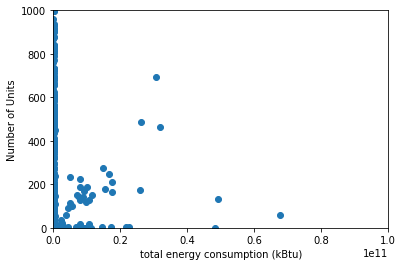

In [11]:
plt.scatter(bblnrgdata.Energy, bblnrgdata["UnitsTotal"])
plt.ylim((0, 1000))
plt.xlim((0, 10**11))
plt.xlabel("total energy consumption (kBtu)")
plt.ylabel("Number of Units")

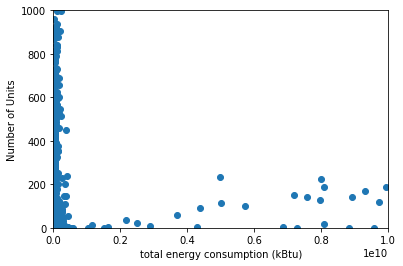

In [12]:
plt.scatter(bblnrgdata.Energy, bblnrgdata["UnitsTotal"])
plt.ylim((0, 1000))
plt.xlim((0, 10**10))
plt.xlabel("total energy consumption (kBtu)")
plt.ylabel("Number of Units")

These are scatter-plots of total energy use vs. number of units for a building.

It seems as if most of our sample has a relatively similar energy consumption despite varying unit counts. Furthermore, the samples with higher energy consumption are not those with the highest number of units, suggesting that a linear relationship likely does not exist. This is our motivation for seeing if there is a log-linear relationship, which will allow us to look at the differences between the samples bunched up on the right side of the plot.

# Scatterplot: Log of Units and Log of Energy

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


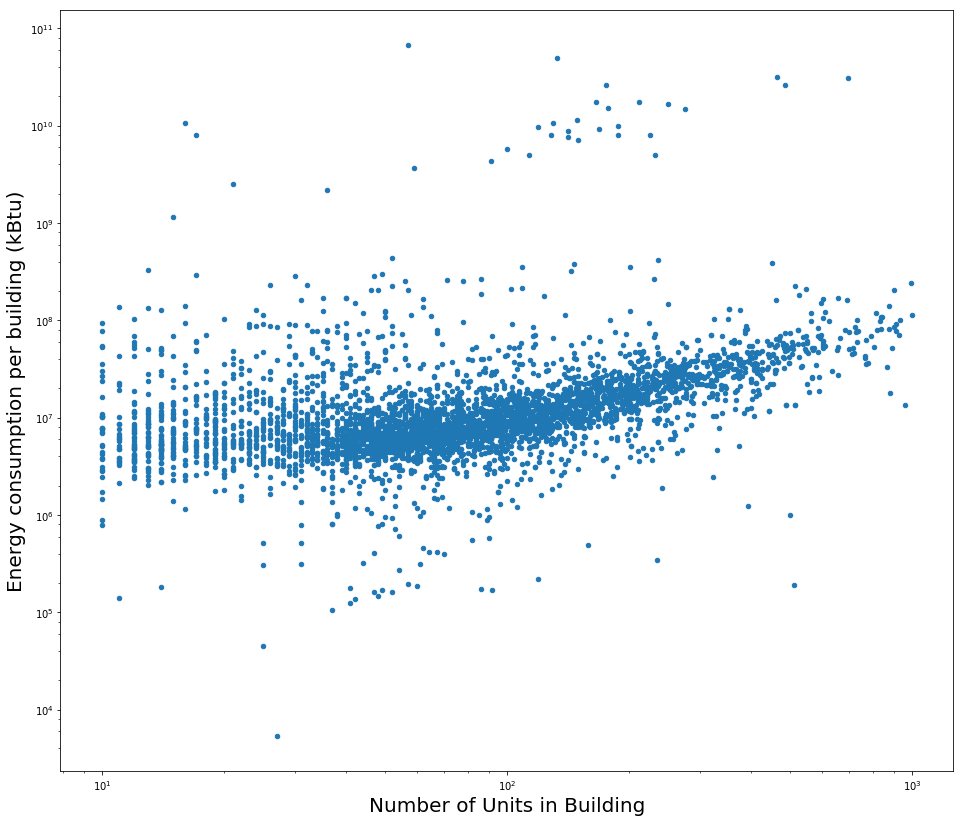

In [13]:
bblnrgdataCut = bblnrgdata[(bblnrgdata.Energy > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='Energy', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

This is also a scatter of number of units and total energy use, but both axes are on the log scale.

Looking at the log scatterplot, there appears to be a log-linear relationship between the two variables.

# Fitting Linear Models to the Log Variables

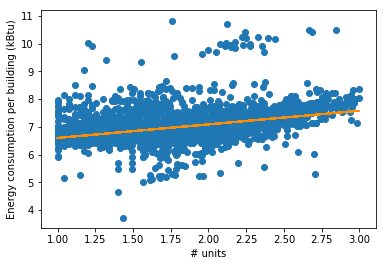

In [14]:
#Units vs. Energy
X = sm.add_constant(np.log10(bblnrgdataCut.UnitsTotal))
linmodel1 = sm.OLS(np.log10(bblnrgdataCut.Energy), X, missing='drop').fit() # ignores entires

plt.scatter(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.Energy))


plt.plot(np.log10(bblnrgdataCut.UnitsTotal), linmodel1.predict(X), '-', color="DarkOrange")

plt.xlabel("# units")
plt.ylabel('Energy consumption per building (kBtu)')

This is a plot showing the line derived from a linear regression for energy consumption as the dependent variable and units as the independent variable. The scatter-plot is plotted too. Both are on the log scale.

In [15]:
linmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.0
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          1.93e-166
Time:                        02:49:42   Log-Likelihood:                -2605.2
No. Observations:                4285   AIC:                             5214.
Df Residuals:                    4283   BIC:                             5227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1089      0.033    186.025      0.000         6.045     6.173
UnitsTotal     0.4904      0.017     28.758      0.000         0.457     0.524
==============================================================================
Omnibus:                     2272.854   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43917.184
Skew:                           2.095   Prob(JB):                         0.00
Kurtosis:                      18.114   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation: the plot shows that the line based on the regression does look like it passes through the distribution of samples pretty well. The R2 value is low but the p-values for our independent variables are 0, suggesting that these variables have good explanatory power but are not sufficient in comprising a complete model. Therefore, we would look to add more variables to improve our R2 and therefore more granular predictive power.

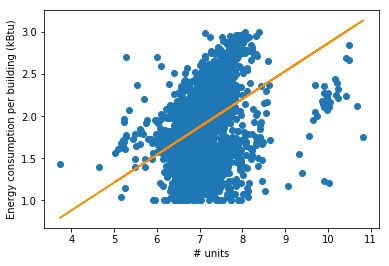

In [16]:
#Energy vs. Units
X = sm.add_constant(np.log10(bblnrgdataCut.Energy))
linmodel2 = sm.OLS(np.log10(bblnrgdataCut.UnitsTotal), X, missing='drop').fit() # ignores entires

plt.scatter(np.log10(bblnrgdataCut.Energy), np.log10(bblnrgdataCut.UnitsTotal))


plt.plot(np.log10(bblnrgdataCut.Energy), linmodel2.predict(X), '-', color="DarkOrange")
plt.xlabel("# units")
plt.ylabel('Energy consumption per building (kBtu)')

This is a plot showing the line derived from a linear regression for energy consumption as the independent variable and units as the dependent variable. The scatter-plot is plotted too. Both are on the log scale.

In [17]:
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.0
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          1.93e-166
Time:                        02:49:43   Log-Likelihood:                -1756.8
No. Observations:                4285   AIC:                             3518.
Df Residuals:                    4283   BIC:                             3530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4369      0.081     -5.400      0.000        -0.596    -0.278
Energy         0.3300      0.011     28.758      0.000         0.308     0.353
==============================================================================
Omnibus:                      144.802   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.337
Skew:                          -0.457   Prob(JB):                     2.51e-35
Kurtosis:                       3.241   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation: the plot shows that the line based on the regression does look like it passes through the distribution of samples pretty well. The R2 value is low but the p-values for our independent variables are 0, suggesting that these variables have good explanatory power but are not sufficient in comprising a complete model. Therefore, we would look to add more variables to improve our R2 and therefore more granular predictive power.

# Using Chi-Squared to determine whether UvE or EvU is a better model

In [18]:
#Chi Square
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [19]:
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))
errorsInLogNrg = np.abs(errorsnrg / (bblnrgdataCut.Energy * np.log(10)))

errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)
errorsInLogUnits = np.abs(errorsunits / (bblnrgdataCut.UnitsTotal * np.log(10)))

UvE_predict = sm.add_constant(np.log10(bblnrgdataCut.UnitsTotal))
EvU_predict = sm.add_constant(np.log10(bblnrgdataCut.Energy))

chi2_UvE = chi2(np.log10(bblnrgdataCut.Energy), linmodel1.fittedvalues, errorsInLogNrg)

chi2_EvU = chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel2.fittedvalues, errorsInLogUnits)

print(chi2_UvE, chi2_EvU)

3.56979723055e+12 491759.260372


The chi-squared for the function with energy as the independent variable is lower than the function with units as the independent variable. A lower chi-squared corresponds to a higher p-value, which means there are more predicted points that are likely to fall within the distribution of observed points. Therefore, the function with energy as the independent variable is the function with the better fit.

# Creating a Quadratic UvE model

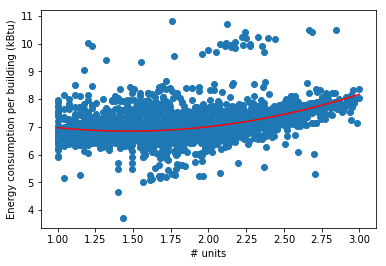

In [20]:
#Quadratic

df = bblnrgdataCut.copy()
df["x"] = np.log10(bblnrgdataCut.UnitsTotal).copy()
df['x2'] = (np.log10(bblnrgdataCut.UnitsTotal)**2).copy()
df["y"] = np.log10(bblnrgdataCut.Energy).copy()

quadModel = smf.ols('y ~ x2 + x', data = df).fit()
quadModel.summary()

test = df[['x', 'y', 'x2']]
test = test.sort_values(by = 'x')

plt.scatter(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.Energy))

plt.plot(test.x, quadModel.predict(test), color = 'r')
plt.xlabel("# units")
plt.ylabel('Energy consumption per building (kBtu)')

This is a plot showing the curve derived from a quadratic linear regression for energy consumption as the dependent variable and units as the independent variable. The scatter-plot is plotted too. Both are on the log scale.

In [21]:
quadModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     612.9
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          8.24e-235
Time:                        02:49:43   Log-Likelihood:                -2444.1
No. Observations:                4285   AIC:                             4894.
Df Residuals:                    4282   BIC:                             4913.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.0731      0.112     72.104      0.000         7.854     8.293
x2             0.5682      0.031     18.288      0.000         0.507     0.629
x             -1.6706      0.119    -14.003      0.000        -1.905    -1.437
==============================================================================
Omnibus:                     2423.017   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57853.466
Skew:                           2.219   Prob(JB):                         0.00
Kurtosis:                      20.445   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation: the plot shows that the line based on the regression does look like it passes through the distribution of samples pretty well. The R2 value is low but the p-values for our independent variables are 0, suggesting that these variables have good explanatory power but are not sufficient in comprising a complete model. Therefore, we would look to add more variables to improve our R2 and therefore more granular predictive power.

The quadratic model does a better job of matching our distribution than the linear models, with a slightly higher R2 than our linear models.

# Likelihood Ratio Test - Comparing UvE linear and UvE quadratic

In [22]:
quadModel.compare_lr_test(linmodel1)

(322.25132713540916, 4.6829415120348471e-72, 1.0)

P value is less than .05, so you can reject the null hypothesis - therefore the complex model is better than the simpler model.

Grade: 9/10 - explanation for error formulae missing